In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_csv('Data/chosen_data.csv')
data.drop('Unnamed: 0', inplace=True, axis=1)

np.random.seed(42)

X,y = data.drop('diagnosed_diabetes', axis=1), data['diagnosed_diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

X_train

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,screen_time_hours_per_day,waist_to_hip_ratio,diastolic_bp,ldl_cholesterol,triglycerides,family_history_diabetes
57105,35,1,134,7.9,7.7,0.82,70,84,97,0
660816,64,4,72,5.2,8.5,0.81,66,118,123,0
295318,50,2,91,6.2,6.7,0.85,77,80,156,0
447035,61,3,116,4.7,5.9,0.94,74,103,151,0
106260,31,3,65,6.7,10.2,0.82,73,129,85,0
...,...,...,...,...,...,...,...,...,...,...
525621,32,4,216,2.3,7.2,0.90,84,103,129,0
359213,54,2,89,6.2,7.0,0.87,71,81,127,0
196287,59,4,100,5.5,4.1,0.81,85,112,114,0
141263,60,1,65,6.2,3.5,0.91,78,120,151,0


# Optuna

In [2]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


def objective(trial):
    global X_train, y_train, X_val, y_val
    # 1. Define the Hyperparameter Search Space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),

        # --- Tree Pruning Parameter ---
        "ccp_alpha": trial.suggest_float("ccp_alpha", 0.0, 0.05),

        "min_samples_split": trial.suggest_int("min_samples_split", 2, 32),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "n_jobs": -1, # Use all CPU cores for speed
        "random_state": 42
    }

    # 2. Initialize and Train the Model
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)

    # 3. Evaluate on Validation Set
    score = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

    return score

# Metric

In [3]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, classification_report, ConfusionMatrixDisplay, \
    RocCurveDisplay


def metrics(preds:np.ndarray, probs:np.ndarray, lables:np.ndarray, method:str):
    cf_mtx = confusion_matrix(lables, preds)
    fpr, tpr, thresholds = roc_curve(lables, probs)
    roc_area = roc_auc_score(lables, probs)
    accuracy = accuracy_score(lables, preds)

    print(classification_report(lables, preds))

    text = f"{roc_area=}\n{accuracy=}"

    cf_mtx_disp = ConfusionMatrixDisplay(confusion_matrix=cf_mtx)
    roc_disp = RocCurveDisplay(fpr=fpr,tpr=tpr)

    fig, (ax_report, ax_matrix, ax_roc) = plt.subplots(1, 3, figsize=(16, 4))
    ax_report.text(
        x=0.05,
        y=0.95,
        s=text,
        family='monospace',
        fontsize=16,
        verticalalignment='top',
        transform=ax_report.transAxes)
    ax_report.set_title(f'Metrics for {method}')
    ax_report.axis('off')

    ax_matrix.set_title("Confusion Matrix")
    ax_matrix.grid(False)
    ax_matrix = cf_mtx_disp.plot(ax=ax_matrix, cmap='grey')

    ax_roc.set_title('ROC Curve')
    ax_roc.plot(fpr,tpr, linewidth=2, label='ROC Curve', color='red')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')


    return {"accuracy": accuracy, "roc_score": roc_area}

# Running Study

[I 2025-12-29 01:36:58,095] A new study created in memory with name: no-name-bc2de751-5524-4627-9bb9-7d8e136c2f4c


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-29 01:39:21,657] Trial 1 finished with value: 0.6635879220203633 and parameters: {'n_estimators': 265, 'ccp_alpha': 0.009522155888367573, 'min_samples_split': 27, 'max_features': 'log2'}. Best is trial 0 with value: 0.6847273233740239.
[I 2025-12-29 01:42:47,845] Trial 2 finished with value: 0.5786653432374709 and parameters: {'n_estimators': 794, 'ccp_alpha': 0.012970696345253703, 'min_samples_split': 24, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6847273233740239.
[I 2025-12-29 02:03:07,642] Trial 3 finished with value: 0.6304204224234923 and parameters: {'n_estimators': 608, 'ccp_alpha': 0.011253485807445418, 'min_samples_split': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.6847273233740239.
[I 2025-12-29 02:08:11,367] Trial 4 finished with value: 0.5 and parameters: {'n_estimators': 754, 'ccp_alpha': 0.036690680046719146, 'min_samples_split': 16, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6847273233740239.
[I 2025-12-29 02:12:01,572] 

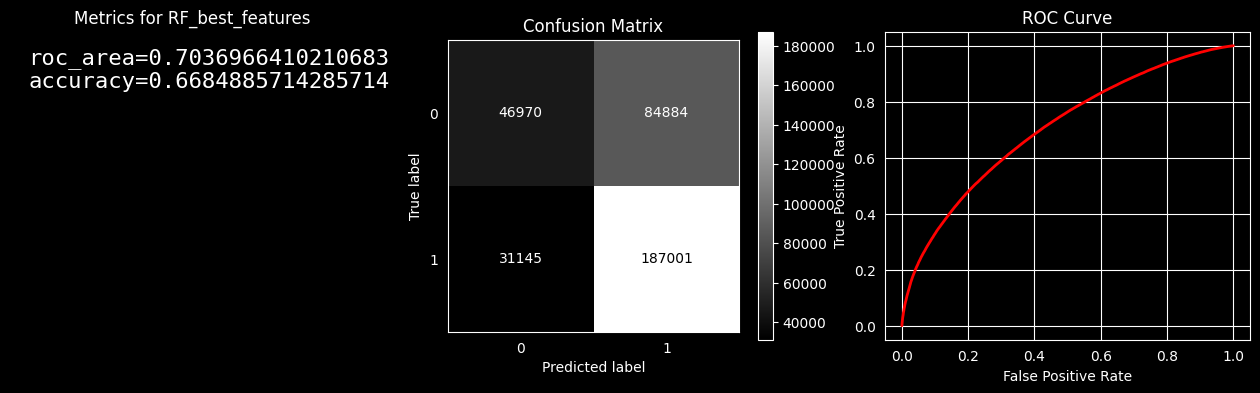

In [4]:
import pickle
import time

study = optuna.create_study(direction="maximize")

start = time.time()
study.optimize(objective, n_trials=50, show_progress_bar=True)
stop = time.time()

model = RandomForestClassifier(**study.best_params)

name = 'RF_best_features'
with open(f'models/{name}.pkl', 'wb') as f:
    pickle.dump(model, f)


model.fit(X_train, y_train)

results = metrics(model.predict(X_test), model.predict_proba(X_test)[:,1], y_test, name)

df_metric = pd.DataFrame.from_dict(results, orient='index')

df_stats = pd.DataFrame(
    {
        "time": [stop-start],
    }
)

result_df = pd.concat([df_metric, df_stats], axis=0)

result_df.to_csv(f'models/results_{name}.csv')
